[Reference](https://medium.com/its-tinkoff/forecasting-with-etna-fast-and-furious-1b58e1453809)

In [1]:
!pip install --upgrade pip
!pip install etna

     |████████████████████████████████| 1.7 MB 23.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 151 kB 32.5 MB/s            
     |████████████████████████████████| 74 kB 4.1 MB/s             
     |████████████████████████████████| 57 kB 6.7 MB/s             
     |████████████████████████████████| 9.5 MB 57.0 MB/s            
     |████████████████████████████████| 178 kB 61.3 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 76.3 MB 60 kB/s              
     |████████████████████████████████| 918 kB 55.5 MB/s            
     |████████████████████████████████| 155 kB 62.7 MB/s            
     |████████████████████████████████| 22.3 MB 88.9 MB/s            
     |████████████████████████████████| 3.4 MB 61.0 MB/s            
     |████████████████████████████████| 131 kB 64.7 MB/s            

In [2]:
!pip show etna

Name: etna
Version: 1.5.0
Summary: ETNA is the first python open source framework of Tinkoff.ru AI Center. It is designed to make working with time series simple, productive, and fun.
Home-page: https://github.com/tinkoff-ai/etna
Author: Andrey Alekseev
Author-email: an.alekseev@tinkoff.ru
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: boto3, catboost, dill, holidays, hydra-slayer, ipywidgets, loguru, numba, omegaconf, pandas, ruptures, saxpy, scikit-learn, seaborn, statsmodels, toml, typer
Required-by: 


In [3]:
import pandas as pd

url = r"https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
df = pd.read_csv(url)
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
usecols = ["date", "location", "new_cases_per_million"]
countries = ["Russia", "United States", "Germany", "Canada", "Italy", "Australia"]
df = df[df.location.isin(countries)][usecols]
df = df.sort_values(["date", "location"]).reset_index(drop=True)
df.tail(10)

,date,location,new_cases_per_million
4255,2022-01-05,Germany,802.582
4256,2022-01-05,Italy,3132.283
4257,2022-01-05,Russia,107.133
4258,2022-01-05,United States,1872.273
4259,2022-01-06,Australia,3033.517
4260,2022-01-06,Canada,1101.978
4261,2022-01-06,Germany,704.525
4262,2022-01-06,Italy,3634.905
4263,2022-01-06,Russia,104.028
4264,2022-01-06,United States,2363.341


In [5]:
from etna.datasets import TSDataset

df_for_ts = df.rename(columns={
    "date":"timestamp",
    "location":"segment",
    "new_cases_per_million":"target"
})
df_for_ts = TSDataset.to_dataset(df_for_ts)
ts = TSDataset(df_for_ts, freq="D")
ts.tail()

/usr/local/lib/python3.7/dist-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/usr/local/lib/python3.7/dist-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/usr/local/lib/python3.7/dist-packages/etna/settings.py:53: UserWarning: etna[prophet] is not available, to install it, run `pip install etna[prophet]`
  warnings.warn("etna[prophet] is not available, to install it, run `pip install etna[prophet]`")


segment,Australia,Canada,Germany,Italy,Russia,United States
feature,target,target,target,target,target,target
timestamp,,,,,,
2022-01-02,1148.121,515.158,150.607,1012.747,123.965,745.457
2022-01-03,1735.095,864.219,596.099,1126.998,110.978,3518.549
2022-01-04,2772.390,2211.574,737.839,2829.951,108.010,2400.579
2022-01-05,2924.824,1023.986,802.582,3132.283,107.133,1872.273
2022-01-06,3033.517,1101.978,704.525,3634.905,104.028,2363.341


# Exploratory Data Analysis


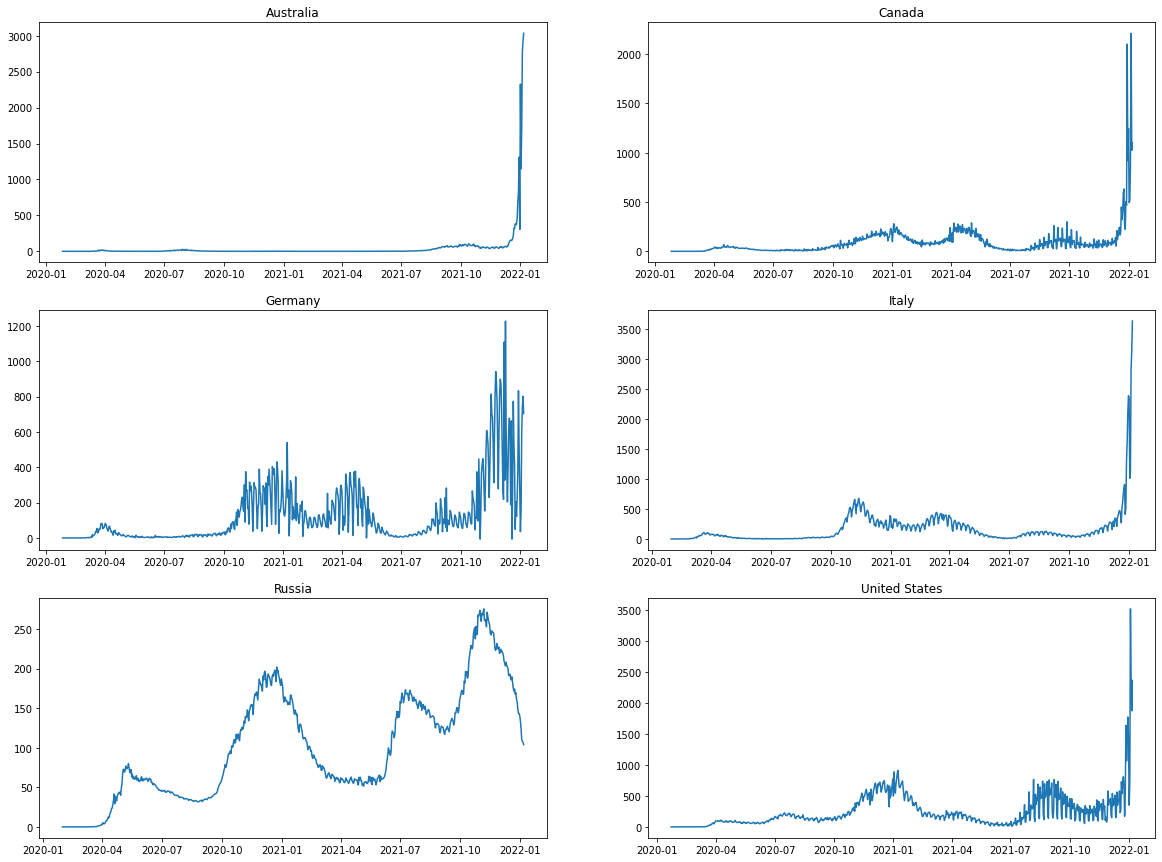

In [6]:
ts.plot()

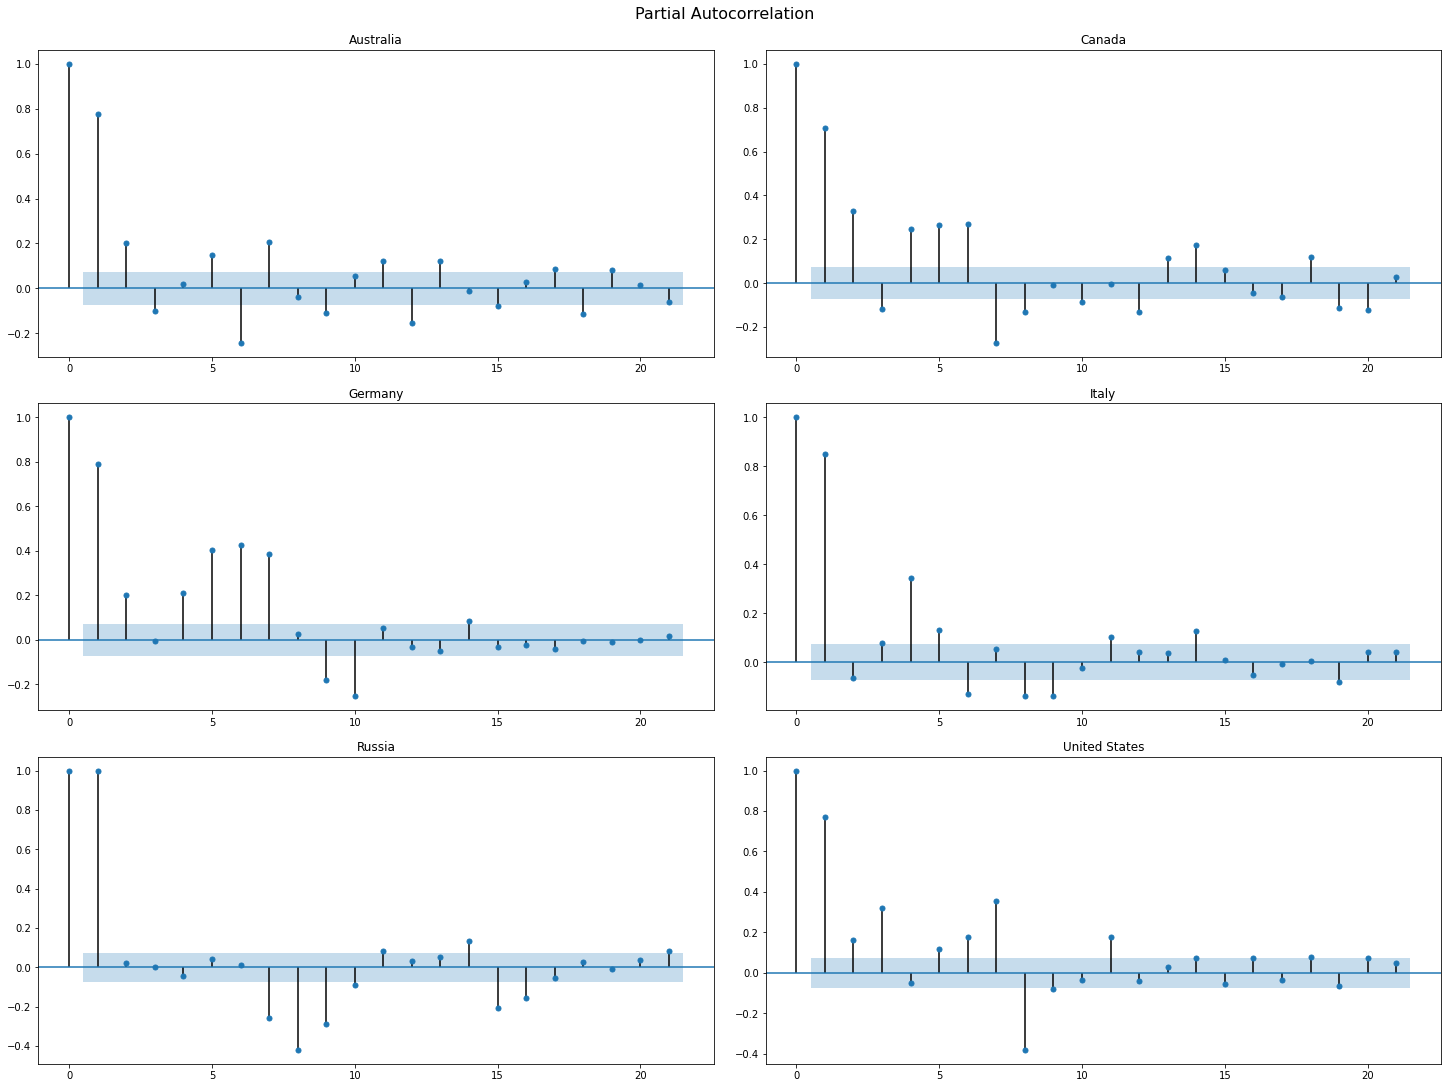

In [7]:
from etna.analysis import sample_pacf_plot

sample_pacf_plot(ts, lags=21)

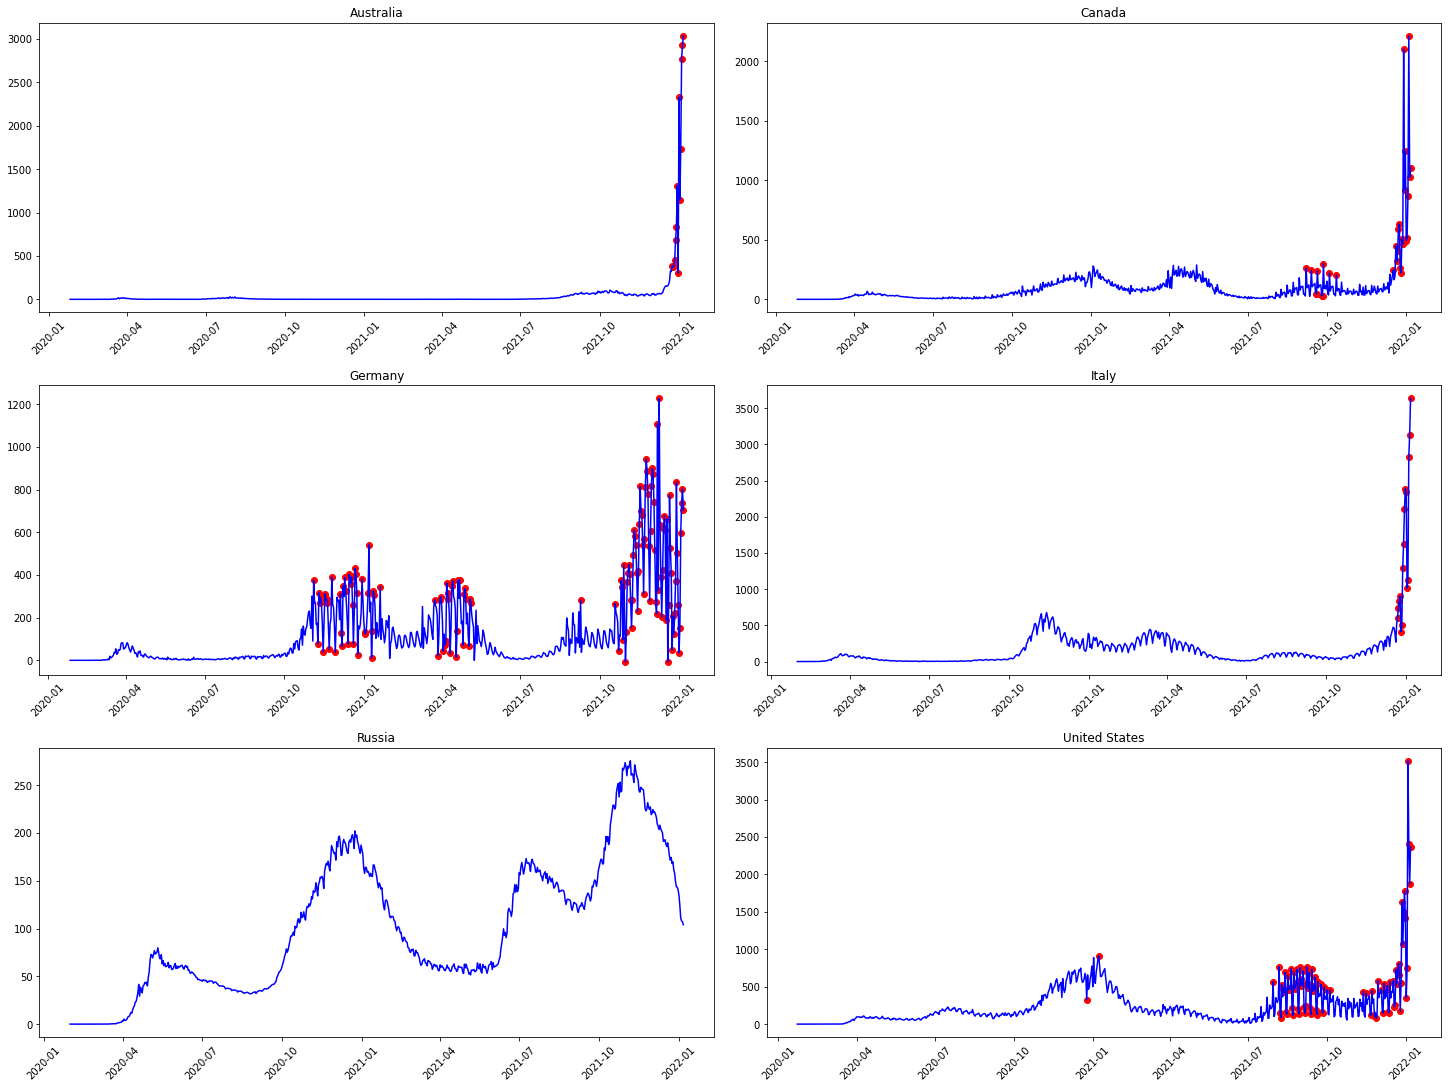

In [8]:
from etna.analysis.outliers import get_anomalies_density
from etna.analysis import plot_anomalies

anomaly_seq_dict = get_anomalies_density(
  ts, window_size=14, distance_coef=1, n_neighbors=12)
plot_anomalies(ts, anomaly_seq_dict)

# Forecasting


In [9]:
from etna.models import SeasonalMovingAverageModel
from etna.pipeline import Pipeline
from etna.transforms import BinsegTrendTransform

pipeline = Pipeline(
  model=SeasonalMovingAverageModel(window=2, seasonality=7),
  transforms=[
    BinsegTrendTransform(
      in_column="target",
      min_size=12,
      jump=1,
      model="ar",
      n_bkps=30
    ),
  ],
  horizon=14
)

In [10]:
from etna.metrics import MAE, SMAPE, MSE

metrics_list = [MAE(), SMAPE(), MSE()]
metrics_df, backtest_df, _ = pipeline.backtest(
    ts=ts,
    metrics=metrics_list,
    n_folds=8,
    aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   35.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   41.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   48.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   48.1s finished


In [11]:
metrics_df

,segment,MAE,SMAPE,MSE
0,Australia,135.895771,30.661165,214609.888554
1,Canada,82.423277,36.297309,49244.000452
2,Germany,148.471830,42.327425,58032.625348
3,Italy,153.923310,26.060924,215990.447223
4,Russia,15.140675,8.211212,316.616102
5,United States,199.813070,37.136864,175187.351835


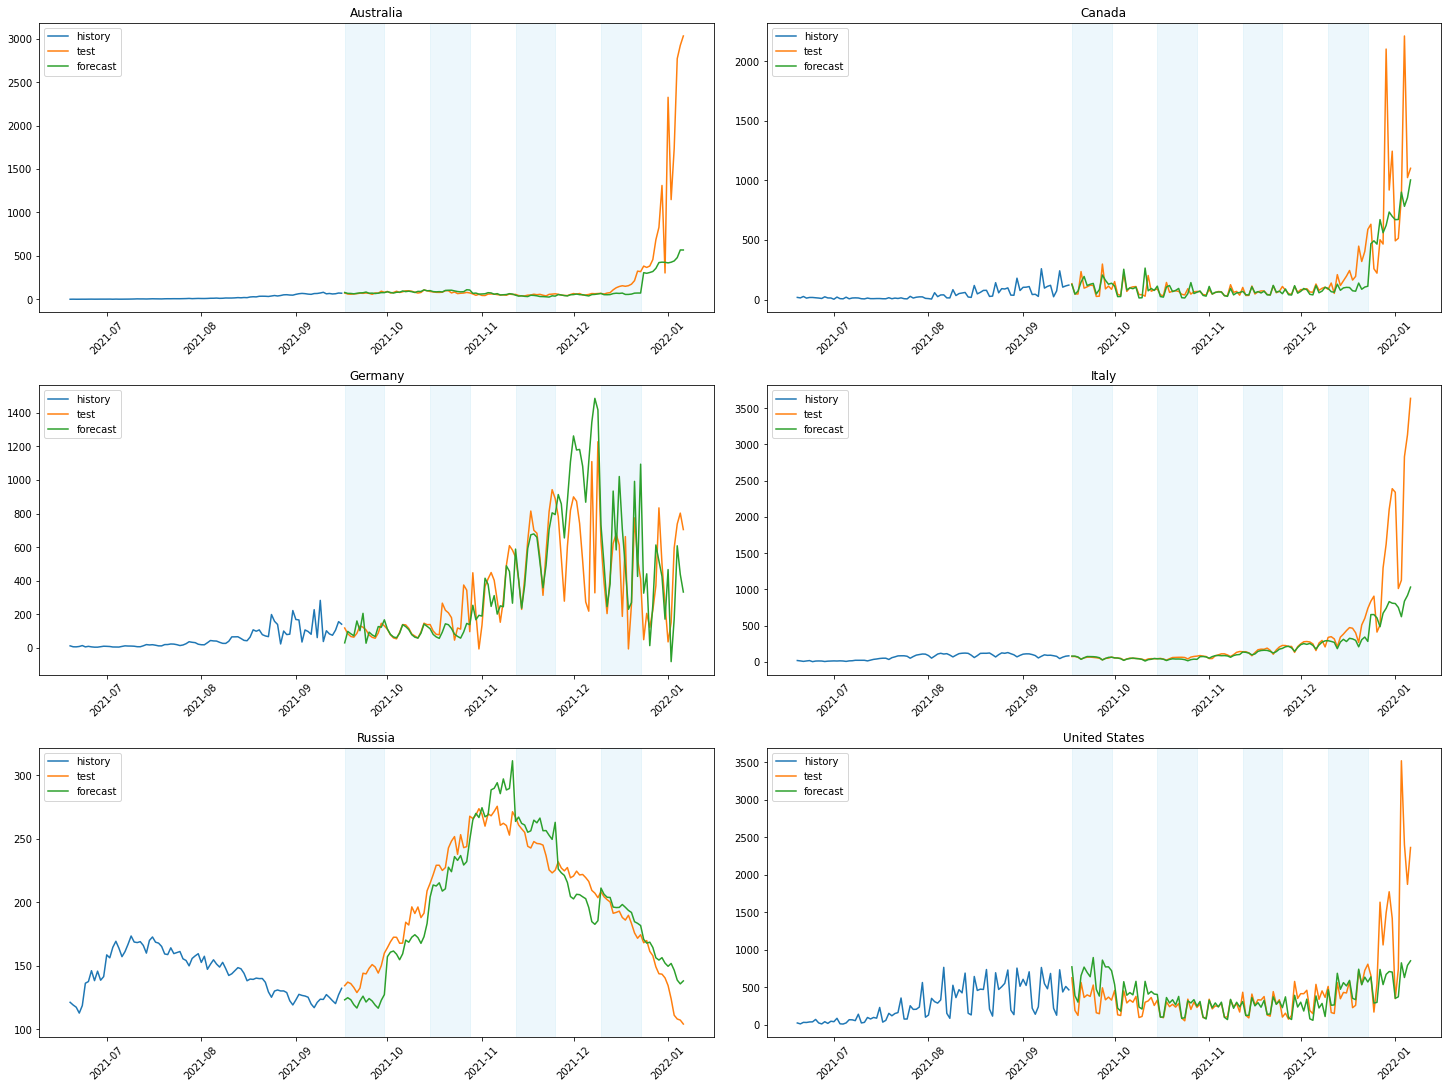

In [12]:
from etna.analysis.plotters import plot_backtest

plot_backtest(backtest_df, ts, history_len=90)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.8s finished


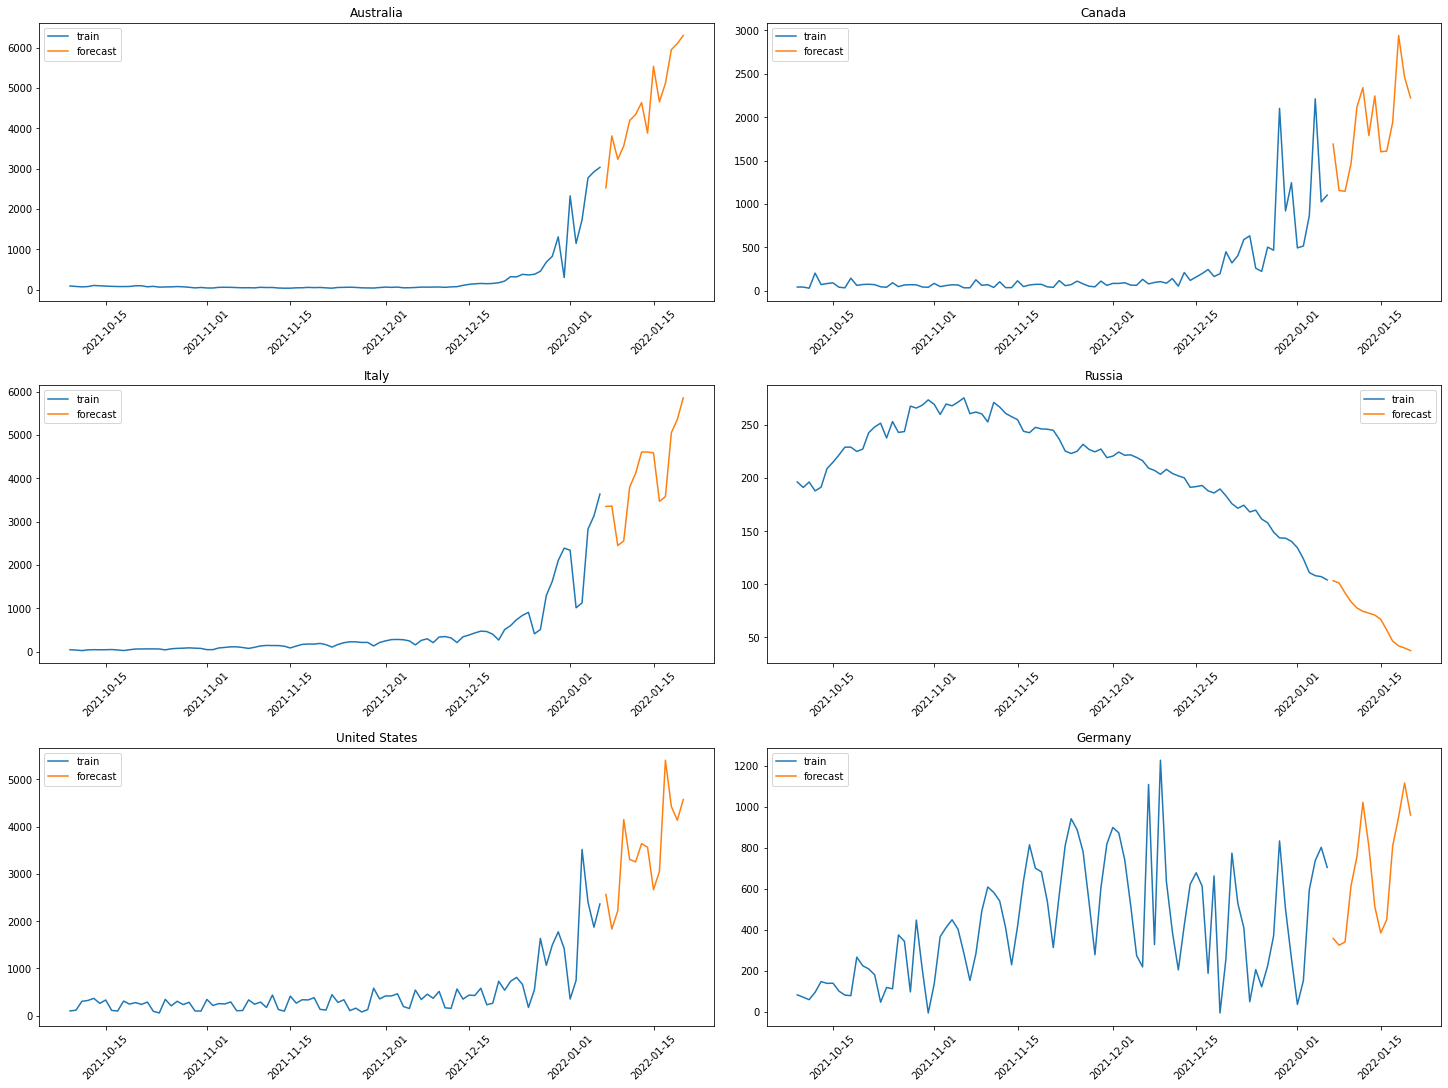

In [13]:
from etna.analysis.plotters import plot_forecast

pipeline.fit(ts)
forecast_df = pipeline.forecast(ts)
plot_forecast(forecast_df, train_ts=ts, n_train_samples=90)